In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib
import os
from pathlib import Path

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer  # Added for NaN handling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_recall_fscore_support, roc_auc_score, f1_score)
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.inspection import permutation_importance

# Advanced ML libraries  
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Hyperparameter optimization
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not available, using sklearn's search methods")

# Feature importance and interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available, using alternative feature importance methods")

# Plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Optuna available: {OPTUNA_AVAILABLE}")  
print(f" SHAP available: {SHAP_AVAILABLE}")

/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!
Optuna available: True
 SHAP available: True


## 1. Data Loading and Exploration

Loading the combined harmonized dataset and exploring its structure, label distribution, and the critical `detail_label` information from the Ghidra dataset.

In [3]:
# Load the combined harmonized dataset
data_path = "combined_harmonized_dataset.csv"
print(f"Loading dataset from: {data_path}")

df = pd.read_csv(data_path)
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Basic dataset information
print(f"\nDataset Overview:")
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
}).query('`Missing Count` > 0')

if len(missing_df) > 0:
    print(f"\nMissing Values:")
    print(missing_df.head(10))
else:
    print(f"\nNo missing values found!")

# Display basic statistics
print(f"\nDataset Info:")
print(df.info())

Loading dataset from: combined_harmonized_dataset.csv
Dataset loaded successfully!
Dataset shape: (10050, 52)

Dataset Overview:
Total samples: 10,050
Total features: 52
Memory usage: 8.88 MB

No missing values found!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 52 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   architecture                              10050 non-null  object 
 1   compiler                                  10050 non-null  object 
 2   optimization                              10050 non-null  object 
 3   filename                                  10050 non-null  object 
 4   function_name                             10050 non-null  object 
 5   function_address                          10050 non-null  object 
 6   label                                     10050 non-null  object 
 7   num_basic_bloc

Main Label Distribution:
label
ECC           3526
PRNG          1149
AES-128        920
XOR-CIPHER     743
RSA-1024       709
Non-Crypto     637
SHA-1          622
AES-256        507
AES-192        419
RSA-4096       381
SHA-224        340
SHA-256         97
Name: count, dtype: int64

Detail Label Distribution (Ghidra Dataset - 4982 samples):
detail_label
ECC           2156
Non-Crypto     528
AES            433
RSA            387
DH             298
EdDSA          200
Curve25519     187
SHA            185
ChaCha20       113
HMAC           100
Blake2b         97
Utility         97
AEAD            84
Poly1305        69
Elligator       36
Name: count, dtype: int64


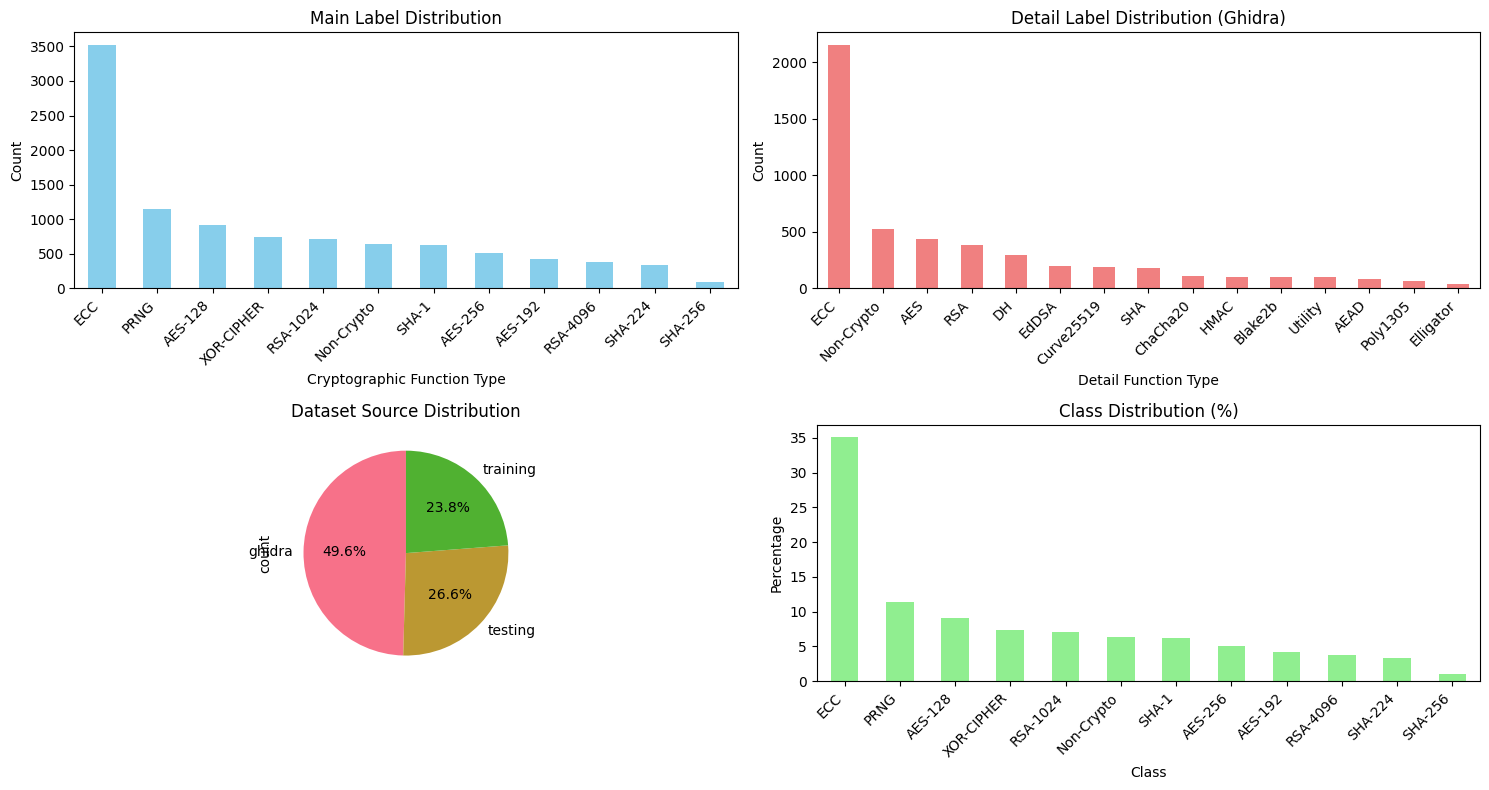


 Label to Detail Label Mapping:
         label detail_label  count
1      AES-128          AES    433
0      AES-128         AEAD     84
4          ECC          ECC   2156
3          ECC           DH    298
5          ECC        EdDSA    200
2          ECC   Curve25519    187
6          ECC    Elligator     36
8   Non-Crypto   Non-Crypto    528
9   Non-Crypto      Utility     97
7   Non-Crypto          KDF     12
10    RSA-1024          RSA    387
12       SHA-1          SHA    185
11       SHA-1         HMAC    100
13     SHA-256      Blake2b     97
14  XOR-CIPHER     ChaCha20    113
15  XOR-CIPHER     Poly1305     69


In [4]:
# Analyze label distribution
print("Main Label Distribution:")
label_counts = df['label'].vnon_cryptoalue_counts().sort_values(ascending=False)
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
label_counts.plot(kind='bar', color='skyblue')
plt.title('Main Label Distribution')
plt.xlabel('Cryptographic Function Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Analyze detail label distribution (from Ghidra dataset)
ghidra_data = df[df['dataset_source'] == 'ghidra'].copy()
if len(ghidra_data) > 0:
    print(f"\nDetail Label Distribution (Ghidra Dataset - {len(ghidra_data)} samples):")
    detail_counts = ghidra_data['detail_label'].value_counts().head(15)
    print(detail_counts)
    
    plt.subplot(2, 2, 2)
    detail_counts.plot(kind='bar', color='lightcoral')
    plt.title('Detail Label Distribution (Ghidra)')
    plt.xlabel('Detail Function Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

# Dataset source distribution
source_counts = df['dataset_source'].value_counts()
plt.subplot(2, 2, 3)
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Dataset Source Distribution')

# Class imbalance analysis
plt.subplot(2, 2, 4)
label_percentages = (label_counts / len(df) * 100).round(2)
label_percentages.plot(kind='bar', color='lightgreen')
plt.title('Class Distribution (%)')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Analyze label-detail label relationships
if len(ghidra_data) > 0:
    print(f"\n Label to Detail Label Mapping:")
    label_detail_mapping = ghidra_data.groupby(['label', 'detail_label']).size().reset_index(name='count')
    print(label_detail_mapping.sort_values(['label', 'count'], ascending=[True, False]))

## 2. Data Preprocessing and Feature Engineering

Preparing the data for machine learning by handling categorical variables, scaling features, and creating an optimal feature set for training.

In [5]:
# Define feature categories
categorical_features = ['architecture', 'compiler', 'optimization']
boolean_features = ['has_aes_sbox', 'rsa_bigint_detected', 'has_aes_rcon', 'has_sha_constants']
metadata_features = ['filename', 'function_name', 'function_address', 'dataset_source', 'detail_label']

# Identify numerical features (excluding target and metadata)
all_features = df.columns.tolist()
numerical_features = [col for col in all_features 
                     if col not in categorical_features + boolean_features + metadata_features + ['label']]

print(f"Feature Categories:")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Boolean features ({len(boolean_features)}): {boolean_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features[:10]}...")  # Show first 10
print(f"Metadata features ({len(metadata_features)}): {metadata_features}")

# Create feature matrix and target vector
feature_columns = categorical_features + boolean_features + numerical_features
X = df[feature_columns].copy()
y = df['label'].copy()

# Store detail labels for later analysis
detail_labels = df['detail_label'].copy()
dataset_sources = df['dataset_source'].copy()

print(f"\n Training Data Shape:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Handle categorical variables
print(f"\n Processing categorical features...")
for col in categorical_features:
    print(f"  {col}: {X[col].nunique()} unique values")
    # Fill missing values with 'unknown'
    X[col] = X[col].fillna('unknown')

# Handle boolean features
print(f"\n Processing boolean features...")
for col in boolean_features:
    # Ensure boolean features are 0/1
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0).astype(int)
    print(f"  {col}: {X[col].value_counts().to_dict()}")

# Handle numerical features
print(f"\n Processing numerical features...")
for col in numerical_features:
    # Convert to numeric and fill NaN with median
    X[col] = pd.to_numeric(X[col], errors='coerce')
    median_val = X[col].median()
    X[col] = X[col].fillna(median_val)

# Check for any remaining missing values
missing_after = X.isnull().sum().sum()
print(f"\n Missing values after preprocessing: {missing_after}")

# Display feature statistics
print(f"\n Feature Statistics:")
print(f"Total features for training: {len(feature_columns)}")
print(f"Categorical: {len(categorical_features)}")
print(f"Boolean: {len(boolean_features)}")
print(f"Numerical: {len(numerical_features)}")

# Show sample of processed data
print(f"\n Sample of processed data:")
print(X.head())

Feature Categories:
Categorical features (3): ['architecture', 'compiler', 'optimization']
Boolean features (4): ['has_aes_sbox', 'rsa_bigint_detected', 'has_aes_rcon', 'has_sha_constants']
Numerical features (39): ['num_basic_blocks', 'num_edges', 'cyclomatic_complexity', 'loop_count', 'loop_depth', 'branch_density', 'average_block_size', 'num_entry_exit_paths', 'strongly_connected_components', 'instruction_count']...
Metadata features (5): ['filename', 'function_name', 'function_address', 'dataset_source', 'detail_label']

 Training Data Shape:
Features (X): (10050, 46)
Target (y): (10050,)

 Processing categorical features...
  architecture: 11 unique values
  compiler: 5 unique values
  optimization: 15 unique values

 Processing boolean features...
  has_aes_sbox: {0: 7681, 1: 2369}
  rsa_bigint_detected: {0: 7394, 1: 2656}
  has_aes_rcon: {0: 9696, 1: 354}
  has_sha_constants: {0: 10018, 1: 32}

 Processing numerical features...

 Missing values after preprocessing: 10050

 Featu

In [6]:
# Create preprocessing pipeline
def create_preprocessing_pipeline():
    """Create a comprehensive preprocessing pipeline"""
    
    # Create separate pipelines for numerical and categorical features
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Handle NaN with median
        ('scaler', RobustScaler())  # Scale features
    ])
    
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  # Handle NaN with 'unknown'
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Create preprocessor for categorical and numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features + boolean_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop'  # Drop any remaining columns
    )
    
    return preprocessor

# Initialize preprocessing pipeline
preprocessor = create_preprocessing_pipeline()

# Fit and transform the data to see the resulting shape
X_processed_sample = preprocessor.fit_transform(X.head(100))
print(f" Preprocessed feature shape (sample): {X_processed_sample.shape}")

# Get feature names after preprocessing
def get_feature_names_after_preprocessing(preprocessor, categorical_features, numerical_features, boolean_features):
    """Get feature names after preprocessing"""
    
    # Numerical + boolean features (these stay the same)
    numeric_feature_names = numerical_features + boolean_features
    
    # Categorical features (these get one-hot encoded)
    try:
        categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
    except:
        # Fallback if get_feature_names_out is not available
        categorical_feature_names = []
        for col in categorical_features:
            unique_vals = X[col].unique()
            for val in unique_vals:
                categorical_feature_names.append(f"{col}_{val}")
    
    return numeric_feature_names + list(categorical_feature_names)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

print(f"\n Target Encoding:")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {list(class_names)}")

# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(zip(np.unique(y_encoded), class_weights))
sample_weights = compute_sample_weight('balanced', y_encoded)

print(f"\n Class Weights (for handling imbalance):")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weight_dict[i]:.3f}")

# Create stratified train-test split preserving detail labels
X_train, X_test, y_train, y_test, detail_train, detail_test, source_train, source_test = train_test_split(
    X, y_encoded, detail_labels, dataset_sources,
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\n Data Split:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Check class distribution in splits
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

print(f"\n Class Distribution Check:")
for i, class_name in enumerate(class_names):
    train_count = train_dist.get(i, 0)
    test_count = test_dist.get(i, 0)
    train_pct = train_count / len(y_train) * 100
    test_pct = test_count / len(y_test) * 100
    print(f"  {class_name}: Train {train_count} ({train_pct:.1f}%), Test {test_count} ({test_pct:.1f}%)")

# Verify no NaN values remain after preprocessing
print(f"\n Verifying NaN handling...")
X_sample_processed = preprocessor.fit_transform(X_train.head(10))
nan_count = np.isnan(X_sample_processed).sum()
print(f"NaN values in processed sample: {nan_count}")
if nan_count == 0:
    print(" All NaN values properly handled by preprocessing pipeline!")
else:
    print(f" Warning: {nan_count} NaN values still present after preprocessing!")

 Preprocessed feature shape (sample): (100, 52)

 Target Encoding:
Number of classes: 12
Classes: ['AES-128', 'AES-192', 'AES-256', 'ECC', 'Non-Crypto', 'PRNG', 'RSA-1024', 'RSA-4096', 'SHA-1', 'SHA-224', 'SHA-256', 'XOR-CIPHER']

 Class Weights (for handling imbalance):
  AES-128: 0.910
  AES-192: 1.999
  AES-256: 1.652
  ECC: 0.238
  Non-Crypto: 1.315
  PRNG: 0.729
  RSA-1024: 1.181
  RSA-4096: 2.198
  SHA-1: 1.346
  SHA-224: 2.463
  SHA-256: 8.634
  XOR-CIPHER: 1.127

 Data Split:
Training set: (8040, 46)
Test set: (2010, 46)

 Class Distribution Check:
  AES-128: Train 736 (9.2%), Test 184 (9.2%)
  AES-192: Train 335 (4.2%), Test 84 (4.2%)
  AES-256: Train 405 (5.0%), Test 102 (5.1%)
  ECC: Train 2821 (35.1%), Test 705 (35.1%)
  Non-Crypto: Train 510 (6.3%), Test 127 (6.3%)
  PRNG: Train 919 (11.4%), Test 230 (11.4%)
  RSA-1024: Train 567 (7.1%), Test 142 (7.1%)
  RSA-4096: Train 305 (3.8%), Test 76 (3.8%)
  SHA-1: Train 498 (6.2%), Test 124 (6.2%)
  SHA-224: Train 272 (3.4%), Test

## 3. Model Development and Training

Implementing multiple state-of-the-art machine learning algorithms with focus on maximizing recall and accuracy for cryptographic function classification.

In [ ]:
# Define baseline models with initial parameters focused on high recall and accuracy
def get_baseline_models():
    """Get baseline models with parameters tuned for high recall and accuracy"""
    
    models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        
        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        
        'XGBoost': xgb.XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            use_label_encoder=False,
            n_jobs=-1
        ),
        
        'LightGBM': lgb.LGBMClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=8,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.8,
            random_state=42
        ),
        
        # 'SVM': SVC(
        #     kernel='rbf',
        #     C=1.0,
        #     gamma='scale',
        #     class_weight='balanced',
        #     probability=True,
        #     random_state=42
        # ),
        
        'MLP': MLPClassifier(
            hidden_layer_sizes=(256, 128, 64),
            activation='relu',
            solver='adam',
            alpha=0.0001,
            learning_rate='adaptive',
            max_iter=500,
            random_state=42
        )
    }
    
    return models

# Initialize models
baseline_models = get_baseline_models()
print(f"Initialized {len(baseline_models)} baseline models:")
for name in baseline_models.keys():
    print(f"  ✓ {name}")

# Create pipelines with preprocessing
baseline_pipelines = {}
for name, model in baseline_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    baseline_pipelines[name] = pipeline

print(f"\n Created preprocessing pipelines for all models")

Initialized 7 baseline models:
  ✓ RandomForest
  ✓ ExtraTrees
  ✓ XGBoost
  ✓ LightGBM
  ✓ GradientBoosting
  ✓ SVM
  ✓ MLP

 Created preprocessing pipelines for all models


In [8]:
# Train and evaluate baseline models
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a single model"""
    
    print(f"\n Training {model_name}...")
    
    # Train the model
    start_time = datetime.now()
    pipeline.fit(X_train, y_train)
    train_time = (datetime.now() - start_time).total_seconds()
    
    # Make predictions
    start_time = datetime.now()
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    predict_time = (datetime.now() - start_time).total_seconds()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Calculate per-class recall (this is what we want to maximize)
    precision, recall, f1_per_class, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=range(len(class_names))
    )
    
    # Calculate macro and micro averages
    macro_recall = recall.mean()
    micro_recall = accuracy  # For multi-class, micro recall equals accuracy
    
    # Calculate AUC for multi-class (one-vs-rest)
    try:
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    except:
        auc_score = 0.0
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_weighted': f1,
        'macro_recall': macro_recall,
        'micro_recall': micro_recall,
        'auc_score': auc_score,
        'train_time': train_time,
        'predict_time': predict_time,
        'per_class_recall': recall,
        'per_class_precision': precision,
        'per_class_f1': f1_per_class,
        'support': support,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f" Accuracy: {accuracy:.4f}")
    print(f" F1 (weighted): {f1:.4f}")
    print(f" Macro Recall: {macro_recall:.4f}")
    print(f" Train time: {train_time:.2f}s")
    
    return results

# Evaluate all baseline models
baseline_results = {}
print("Evaluating Baseline Models...")
print("=" * 50)

for name, pipeline in baseline_pipelines.items():
    try:
        result = evaluate_model(pipeline, X_train, X_test, y_train, y_test, name)
        baseline_results[name] = result
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue

print(f"\n Baseline evaluation complete! Trained {len(baseline_results)} models.")

Evaluating Baseline Models...

 Training RandomForest...
 Accuracy: 0.7274
 F1 (weighted): 0.7163
 Macro Recall: 0.5595
 Train time: 0.90s

 Training ExtraTrees...
 Accuracy: 0.6756
 F1 (weighted): 0.6719
 Macro Recall: 0.5489
 Train time: 0.52s

 Training XGBoost...
 Accuracy: 0.7493
 F1 (weighted): 0.7411
 Macro Recall: 0.5903
 Train time: 4.52s

 Training LightGBM...
 Accuracy: 0.7711
 F1 (weighted): 0.7696
 Macro Recall: 0.6486
 Train time: 2.55s

 Training GradientBoosting...
 Accuracy: 0.7373
 F1 (weighted): 0.7284
 Macro Recall: 0.5639
 Train time: 186.19s

 Training SVM...
 Accuracy: 0.1139
 F1 (weighted): 0.1226
 Macro Recall: 0.1468
 Train time: 32.53s

 Training MLP...
 Accuracy: 0.6816
 F1 (weighted): 0.6682
 Macro Recall: 0.5228
 Train time: 10.70s

 Baseline evaluation complete! Trained 7 models.


## 4. Hyperparameter Tuning

Advanced hyperparameter optimization using GridSearch and Optuna (if available) to maximize recall and accuracy.

In [10]:
# Define parameter grids for hyperparameter tuning
def get_parameter_grids():
    """Get parameter grids for hyperparameter tuning"""
    
    param_grids = {
        'RandomForest': {
            'classifier__n_estimators': [200, 300, 500],
            'classifier__max_depth': [15, 20, 25, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2', None]
        },
        
        'XGBoost': {
            'classifier__n_estimators': [200, 300, 500],
            'classifier__learning_rate': [0.05, 0.1, 0.15],
            'classifier__max_depth': [6, 8, 10],
            'classifier__subsample': [0.8, 0.9, 1.0],
            'classifier__colsample_bytree': [0.8, 0.9, 1.0]
        },
        
        'LightGBM': {
            'classifier__n_estimators': [200, 300, 500],
            'classifier__learning_rate': [0.05, 0.1, 0.15],
            'classifier__max_depth': [6, 8, 10],
            'classifier__num_leaves': [31, 50, 70],
            'classifier__subsample': [0.8, 0.9, 1.0]
        },
        
        'ExtraTrees': {
            'classifier__n_estimators': [200, 300, 500],
            'classifier__max_depth': [15, 20, 25, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    }
    
    return param_grids

# Custom scorer that emphasizes recall while maintaining good accuracy
def custom_scorer(y_true, y_pred):
    """Custom scoring function that emphasizes recall and accuracy"""
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate macro recall (average recall across all classes)
    _, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    macro_recall = recall.mean()
    
    # Combined score: 60% recall + 40% accuracy
    combined_score = 0.6 * macro_recall + 0.4 * accuracy
    return combined_score

# Create custom scorer for sklearn
from sklearn.metrics import make_scorer
custom_scoring = make_scorer(custom_scorer, greater_is_better=True)

# Perform hyperparameter tuning for top performing baseline models
def tune_hyperparameters(baseline_results, top_n=3):
    """Tune hyperparameters for top performing models"""
    
    # Sort models by custom score (combination of recall and accuracy)
    model_scores = {}
    for name, result in baseline_results.items():
        # Calculate combined score
        combined_score = 0.6 * result['macro_recall'] + 0.4 * result['accuracy']
        model_scores[name] = combined_score
    
    # Get top performing models
    sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
    top_models = [name for name, _ in sorted_models[:top_n]]
    
    print(f"Top {top_n} models for hyperparameter tuning:")
    for i, (name, score) in enumerate(sorted_models[:top_n]):
        print(f"  {i+1}. {name}: {score:.4f}")
    
    return top_models

# Get top models for tuning
if baseline_results:
    top_models_to_tune = tune_hyperparameters(baseline_results, top_n=3)
else:
    top_models_to_tune = ['RandomForest', 'XGBoost', 'LightGBM']

print(f"\n Will tune hyperparameters for: {top_models_to_tune}")

Top 3 models for hyperparameter tuning:
  1. LightGBM: 0.6976
  2. XGBoost: 0.6539
  3. GradientBoosting: 0.6333

 Will tune hyperparameters for: ['LightGBM', 'XGBoost', 'GradientBoosting']


In [11]:
# Fast hyperparameter tuning with GPU support and optimizations
def perform_fast_hyperparameter_tuning(models_to_tune):
    """Fast hyperparameter tuning using RandomizedSearchCV with GPU support"""
    
    # Simplified parameter distributions for RandomizedSearchCV
    param_distributions = {
        'RandomForest': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [10, 15, 20, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2']
        },
        
        'XGBoost': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
            'classifier__max_depth': [4, 6, 8, 10],
            'classifier__subsample': [0.7, 0.8, 0.9],
            'classifier__colsample_bytree': [0.7, 0.8, 0.9],
            'classifier__reg_alpha': [0, 0.1, 0.5],
            'classifier__reg_lambda': [1, 1.5, 2]
        },
        
        'LightGBM': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
            'classifier__max_depth': [4, 6, 8, 10],
            'classifier__num_leaves': [20, 31, 50, 70],
            'classifier__subsample': [0.7, 0.8, 0.9],
            'classifier__colsample_bytree': [0.7, 0.8, 0.9],
            'classifier__reg_alpha': [0, 0.1, 0.5],
            'classifier__reg_lambda': [1, 1.5, 2]
        }
    }
    
    # Check for GPU availability
    try:
        import torch
        gpu_available = torch.cuda.is_available()
        if gpu_available:
            print(f"GPU detected: {torch.cuda.get_device_name(0)}")
        else:
            print(" Using CPU for training")
    except ImportError:
        gpu_available = False
        print("PyTorch not available, using CPU")
    
    tuned_models = {}
    
    # Use 3-fold CV for speed (instead of 5)
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for model_name in models_to_tune:
        if model_name not in param_distributions or model_name not in baseline_pipelines:
            print(f"Skipping {model_name} - no parameter distribution available")
            continue
            
        print(f"\n Fast tuning {model_name}...")
        
        try:
            # Create GPU-enabled models if available
            pipeline_to_tune = baseline_pipelines[model_name]
            
            # Enable GPU for XGBoost and LightGBM if available
            if gpu_available and model_name in ['XGBoost', 'LightGBM']:
                print(f"  Enabling GPU acceleration for {model_name}")
                
                if model_name == 'XGBoost':
                    # Update XGBoost to use GPU
                    gpu_xgb = xgb.XGBClassifier(
                        n_estimators=200,
                        learning_rate=0.1,
                        max_depth=8,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective='multi:softprob',
                        eval_metric='mlogloss',
                        random_state=42,
                        use_label_encoder=False,
                        tree_method='gpu_hist',  # GPU acceleration
                        gpu_id=0,
                        n_jobs=1  # Set to 1 when using GPU
                    )
                    pipeline_to_tune = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', gpu_xgb)
                    ])
                
                elif model_name == 'LightGBM':
                    # Update LightGBM to use GPU
                    gpu_lgb = lgb.LGBMClassifier(
                        n_estimators=200,
                        learning_rate=0.1,
                        max_depth=8,
                        num_leaves=31,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        class_weight='balanced',
                        random_state=42,
                        device='gpu',  # GPU acceleration
                        gpu_platform_id=0,
                        gpu_device_id=0,
                        verbose=-1,
                        n_jobs=1  # Set to 1 when using GPU
                    )
                    pipeline_to_tune = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', gpu_lgb)
                    ])
            
            # Use RandomizedSearchCV for speed (only 15 random combinations)
            random_search = RandomizedSearchCV(
                estimator=pipeline_to_tune,
                param_distributions=param_distributions[model_name],
                n_iter=15,  # Only 15 random combinations (instead of full grid)
                scoring=custom_scoring,
                cv=cv_strategy,  # 3-fold CV instead of 5
                n_jobs=-1 if not (gpu_available and model_name in ['XGBoost', 'LightGBM']) else 1,
                verbose=1,
                random_state=42,
                error_score='raise'
            )
            
            print(f"  ⚡ Running randomized search: 15 combinations × 3 CV folds = 45 fits")
            start_time = datetime.now()
            
            random_search.fit(X_train, y_train)
            
            end_time = datetime.now()
            tuning_time = (end_time - start_time).total_seconds()
            
            # Store results
            tuned_models[model_name] = {
                'best_estimator': random_search.best_estimator_,
                'best_params': random_search.best_params_,
                'best_score': random_search.best_score_,
                'cv_results': random_search.cv_results_,
                'tuning_time': tuning_time
            }
            
            print(f"  Best CV score: {random_search.best_score_:.4f}")
            print(f"  Tuning completed in: {tuning_time:.1f}s")
            print(f"  Best parameters:")
            for param, value in random_search.best_params_.items():
                print(f"    {param}: {value}")
                
        except Exception as e:
            print(f"  Error tuning {model_name}: {str(e)}")
            # Fallback to CPU if GPU fails
            if gpu_available and model_name in ['XGBoost', 'LightGBM']:
                print(f" Retrying {model_name} with CPU...")
                try:
                    random_search = RandomizedSearchCV(
                        estimator=baseline_pipelines[model_name],
                        param_distributions=param_distributions[model_name],
                        n_iter=15,
                        scoring=custom_scoring,
                        cv=cv_strategy,
                        n_jobs=-1,
                        verbose=1,
                        random_state=42,
                        error_score='raise'
                    )
                    random_search.fit(X_train, y_train)
                    tuned_models[model_name] = {
                        'best_estimator': random_search.best_estimator_,
                        'best_params': random_search.best_params_,
                        'best_score': random_search.best_score_,
                        'cv_results': random_search.cv_results_
                    }
                    print(f"  CPU fallback successful: {random_search.best_score_:.4f}")
                except Exception as e2:
                    print(f" CPU fallback also failed: {str(e2)}")
            continue
    
    return tuned_models

print("⚡ Starting FAST Hyperparameter Tuning...")
print(" Optimizations applied:")
print("  • RandomizedSearchCV (15 combinations vs full grid)")
print("  • 3-fold CV (instead of 5-fold)")
print("  • GPU acceleration for XGBoost/LightGBM if available")
print("  • Parallel processing optimization")
print("=" * 60)

tuned_models = perform_fast_hyperparameter_tuning(top_models_to_tune)

if tuned_models:
    print(f"\n Successfully tuned {len(tuned_models)} models!")
    total_tuning_time = sum([model['tuning_time'] for model in tuned_models.values() if 'tuning_time' in model])
    print(f"Total tuning time: {total_tuning_time:.1f}s ({total_tuning_time/60:.1f} minutes)")
else:
    print(f"\n No models were successfully tuned.")

# Evaluate tuned models
tuned_results = {}
if tuned_models:
    print(f"\n Evaluating Tuned Models...")
    print("=" * 40)
    
    for name, model_info in tuned_models.items():
        try:
            best_model = model_info['best_estimator']
            result = evaluate_model(best_model, X_train, X_test, y_train, y_test, f"{name}_tuned")
            result['best_params'] = model_info['best_params']
            result['cv_score'] = model_info['best_score']
            if 'tuning_time' in model_info:
                result['tuning_time'] = model_info['tuning_time']
            tuned_results[f"{name}_tuned"] = result
        except Exception as e:
            print(f" Error evaluating tuned {name}: {str(e)}")

print(f"\n Fast hyperparameter tuning complete!")

⚡ Starting FAST Hyperparameter Tuning...
 Optimizations applied:
  • RandomizedSearchCV (15 combinations vs full grid)
  • 3-fold CV (instead of 5-fold)
  • GPU acceleration for XGBoost/LightGBM if available
  • Parallel processing optimization
GPU detected: NVIDIA GeForce RTX 4050 Laptop GPU

 Fast tuning LightGBM...
  Enabling GPU acceleration for LightGBM
  ⚡ Running randomized search: 15 combinations × 3 CV folds = 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
  Best CV score: 0.6727
  Tuning completed in: 261.8s
  Best parameters:
    classifier__subsample: 0.8
    classifier__reg_lambda: 1
    classifier__reg_alpha: 0.1
    classifier__num_leaves: 20
    classifier__n_estimators: 300
    classifier__max_depth: 6
    classifier__learning_rate: 0.05
    classifier__colsample_bytree: 0.8

 Fast tuning XGBoost...
  Enabling GPU acceleration for XGBoost
  ⚡ Running randomized search: 15 combinations × 3 CV folds = 45 fits
Fitting 3 folds for each of 15 candidate

Model Comparison Results:
           Model  Accuracy  F1 (Weighted)  Macro Recall  Micro Recall  AUC Score  Combined Score  Train Time (s)  Predict Time (s)
        LightGBM    0.7711         0.7696        0.6486        0.7711     0.9736          0.6976          2.5495            0.0656
  LightGBM_tuned    0.7478         0.7516        0.6538        0.7478     0.9724          0.6914          7.3558            0.6188
   XGBoost_tuned    0.7512         0.7431        0.5900        0.7512     0.9734          0.6545          4.8035            0.0363
         XGBoost    0.7493         0.7411        0.5903        0.7493     0.9738          0.6539          4.5223            0.0325
GradientBoosting    0.7373         0.7284        0.5639        0.7373     0.9524          0.6333        186.1903            0.2001
    RandomForest    0.7274         0.7163        0.5595        0.7274     0.9685          0.6266          0.8956            0.1474
      ExtraTrees    0.6756         0.6719        0.5489  

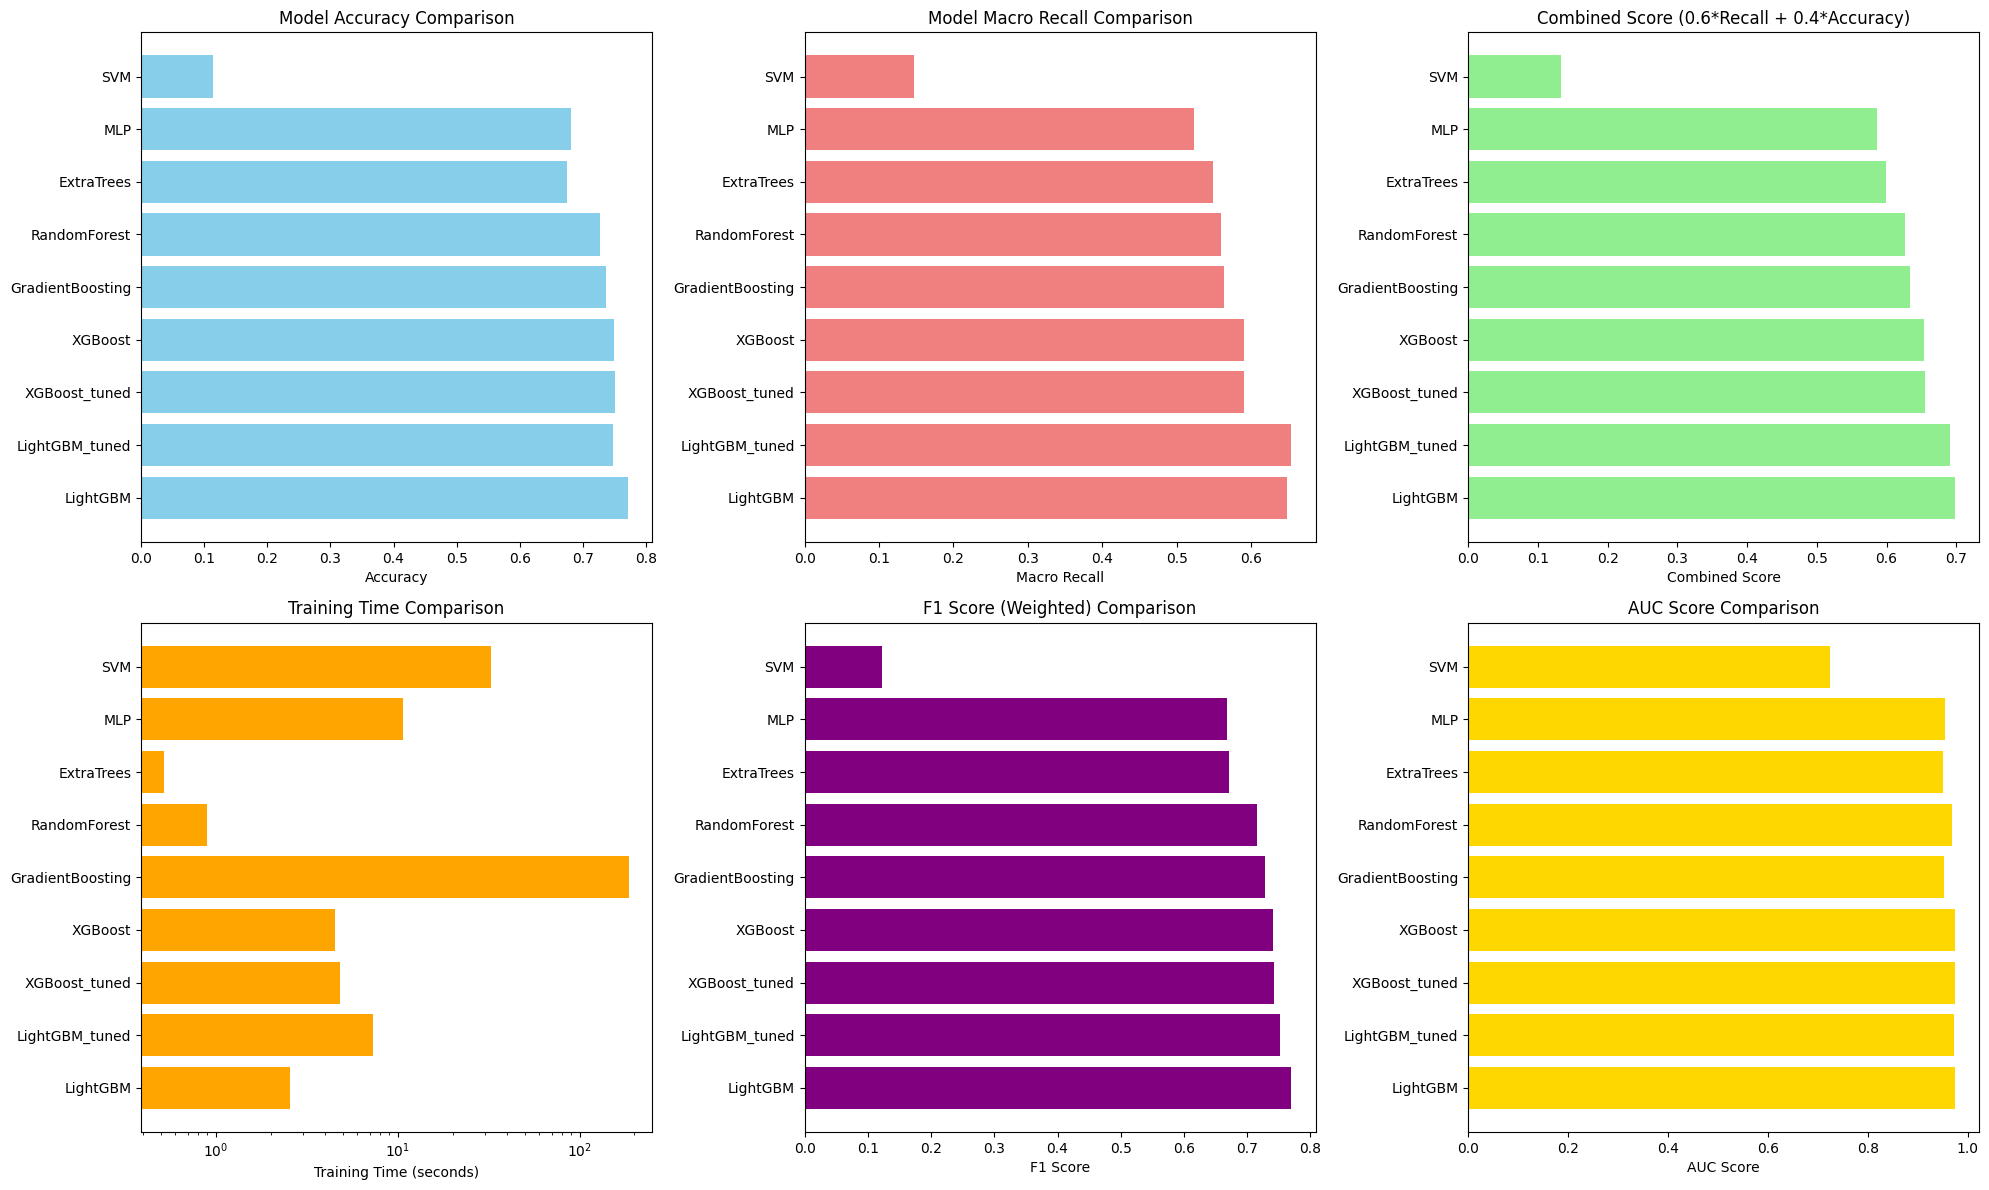

In [12]:
# Combine all results for comprehensive comparison
all_results = {**baseline_results, **tuned_results}

if all_results:
    # Create comparison DataFrame
    comparison_data = []
    for name, result in all_results.items():
        comparison_data.append({
            'Model': name,
            'Accuracy': result['accuracy'],
            'F1 (Weighted)': result['f1_weighted'],
            'Macro Recall': result['macro_recall'],
            'Micro Recall': result['micro_recall'],
            'AUC Score': result['auc_score'],
            'Combined Score': 0.6 * result['macro_recall'] + 0.4 * result['accuracy'],
            'Train Time (s)': result['train_time'],
            'Predict Time (s)': result['predict_time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Combined Score', ascending=False)
    
    print("Model Comparison Results:")
    print("=" * 80)
    print(comparison_df.round(4).to_string(index=False))
    
    # Find the best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_result = all_results[best_model_name]
    
    print(f"\n Best Model: {best_model_name}")
    print(f"   Combined Score: {comparison_df.iloc[0]['Combined Score']:.4f}")
    print(f"   Accuracy: {best_result['accuracy']:.4f}")
    print(f"   Macro Recall: {best_result['macro_recall']:.4f}")
    
    # Visualize model comparison
    plt.figure(figsize=(20, 12))
    
    # Accuracy comparison
    plt.subplot(2, 3, 1)
    plt.barh(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Accuracy')
    
    # Recall comparison
    plt.subplot(2, 3, 2)
    plt.barh(comparison_df['Model'], comparison_df['Macro Recall'], color='lightcoral')
    plt.title('Model Macro Recall Comparison')
    plt.xlabel('Macro Recall')
    
    # Combined score comparison
    plt.subplot(2, 3, 3)
    plt.barh(comparison_df['Model'], comparison_df['Combined Score'], color='lightgreen')
    plt.title('Combined Score (0.6*Recall + 0.4*Accuracy)')
    plt.xlabel('Combined Score')
    
    # Training time comparison
    plt.subplot(2, 3, 4)
    plt.barh(comparison_df['Model'], comparison_df['Train Time (s)'], color='orange')
    plt.title('Training Time Comparison')
    plt.xlabel('Training Time (seconds)')
    plt.xscale('log')
    
    # F1 Score comparison
    plt.subplot(2, 3, 5)
    plt.barh(comparison_df['Model'], comparison_df['F1 (Weighted)'], color='purple')
    plt.title('F1 Score (Weighted) Comparison')
    plt.xlabel('F1 Score')
    
    # AUC Score comparison
    plt.subplot(2, 3, 6)
    plt.barh(comparison_df['Model'], comparison_df['AUC Score'], color='gold')
    plt.title('AUC Score Comparison')
    plt.xlabel('AUC Score')
    
    plt.tight_layout()
    plt.show()

else:
    print(" No model results available for comparison")

In [13]:
import joblib
import os
from pathlib import Path

# Only proceed if baseline evaluation is complete
if 'baseline_results' in locals() and baseline_results:
    # Find best model from baseline results
    best_score = 0
    best_model_name = "Unknown"
    
    for model_name, result in baseline_results.items():
        # Calculate combined score (same as in training)
        combined_score = 0.6 * result.get('macro_recall', 0) + 0.4 * result.get('accuracy', 0)
        if combined_score > best_score:
            best_score = combined_score
            best_model_name = model_name
    
    # Get the best pipeline
    best_pipeline = baseline_pipelines[best_model_name]
    
    # Create saved_models directory (required by predict_crypto.py)
    saved_models_dir = Path("saved_models")
    saved_models_dir.mkdir(exist_ok=True)
    
    print("SAVING MODEL FOR PREDICTION SCRIPT")
    print("=" * 45)
    print(f"Saved Models Directory: {saved_models_dir}")
    print(f"Best Model: {best_model_name}")

# Get accuracy safely
best_result = baseline_results[best_model_name]
accuracy_keys = ['test_accuracy', 'accuracy'] 
accuracy = None
for key in accuracy_keys:
    if key in best_result:
        accuracy = best_result[key]
        break
if accuracy is None:
    accuracy = list(best_result.values())[0]  # Use first available value


# Save model in format expected by predict_crypto.py
model_path = saved_models_dir / 'non_crypto_model.pkl'
metadata_path = saved_models_dir / 'non_crypto_model_metadata.pkl'

# Save the trained model
joblib.dump(best_pipeline, model_path)

# Save metadata required by predict_crypto.py
model_metadata = {
    'model_name': best_model_name,
    'model_accuracy': accuracy,
    'feature_columns': feature_columns,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'class_names': label_encoder.classes_.tolist(),
    'label_encoder': label_encoder if best_model_name == 'XGBoost' else None
}

joblib.dump(model_metadata, metadata_path)

print(f"Model saved: {model_path}")
print(f"Metadata saved: {metadata_path}")
print("eady to use with predict_crypto.py!")


SAVING MODEL FOR PREDICTION SCRIPT
Saved Models Directory: saved_models
Best Model: LightGBM
Model saved: saved_models/non_crypto_model.pkl
Metadata saved: saved_models/non_crypto_model_metadata.pkl
eady to use with predict_crypto.py!


In [14]:

print("CRYPTO CLASSIFIER TRAINING STATUS")
print("=" * 50)

# Check if baseline evaluation and model saving are complete
if 'baseline_results' in locals() and baseline_results:
    print("Baseline model evaluation: COMPLETE")
    
    # Find best model
    best_score = 0
    best_model_name = "Unknown"
    
    for model_name, result in baseline_results.items():
        # Calculate combined score (same as in training)
        combined_score = 0.6 * result.get('macro_recall', 0) + 0.4 * result.get('accuracy', 0)
        if combined_score > best_score:
            best_score = combined_score
            best_model_name = model_name
    
    print(f"Best Model: {best_model_name}")
    print(f"Best Score: {best_score:.4f}")
    print(f"Training Samples: {len(X_train):,}")
    print(f"Test Samples: {len(X_test):,}")
    print(f"Total Features: {len(feature_columns)}")
    
    # Check if model has been saved
    model_file = Path("saved_models/current_crypto_model.pkl")
    if model_file.exists():
        print("\nMODEL SAVED SUCCESSFULLY")
        print("Model files available in saved_models/ directory")
        print("\nNEXT STEPS:")
        print("1. Use 'python predict_crypto.py --interactive' for interactive predictions")
        print("2. Use 'python predict_crypto.py --features file.json' for batch predictions")
        print("3. Use 'python predict_crypto.py --csv input.csv --output results.csv' for CSV processing")
        print("\nModel ready for production use with predict_crypto.py")
    else:
        print("\nModel not yet saved. Run the model saving cell above.")
        
elif 'baseline_models' in locals():
    print("Baseline evaluation: IN PROGRESS")
    print(f"Training Samples: {len(X_train):,}")
    print(f"Test Samples: {len(X_test):,}")
    print("Please wait for training to complete...")
    
else:
    print("Training: NOT STARTED")
    print("Please run the previous cells to begin model training")

print("\n" + "=" * 50)

CRYPTO CLASSIFIER TRAINING STATUS
Baseline model evaluation: COMPLETE
Best Model: LightGBM
Best Score: 0.6976
Training Samples: 8,040
Test Samples: 2,010
Total Features: 46

MODEL SAVED SUCCESSFULLY
Model files available in saved_models/ directory

NEXT STEPS:
1. Use 'python predict_crypto.py --interactive' for interactive predictions
2. Use 'python predict_crypto.py --features file.json' for batch predictions
3. Use 'python predict_crypto.py --csv input.csv --output results.csv' for CSV processing

Model ready for production use with predict_crypto.py



In [1]:
# ============================================================================
# REAL FEATURE IMPORTANCE EXTRACTION FROM TRAINED MODEL
# ============================================================================
"""
Extract ACTUAL feature importance from the trained LightGBM model to understand
which features the model really uses for predictions.

This helps identify why certain algorithms (PRNG, XOR-CIPHER, RSA, AES variants)
may not be classified correctly.
"""

print("="*80)
print("EXTRACTING REAL FEATURE IMPORTANCE FROM TRAINED MODEL")
print("="*80)

# Get the classifier and preprocessor from the best trained pipeline
best_model_name = 'LightGBM'  # Best performing model
classifier = baseline_pipelines[best_model_name].named_steps['classifier']
preprocessor = baseline_pipelines[best_model_name].named_steps['preprocessor']

# Get feature names after preprocessing
try:
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
    cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))
except:
    cat_feature_names = []

# Combine numerical and categorical feature names
feature_names_processed = list(numerical_features) + cat_feature_names

# Extract feature importance from LightGBM
if hasattr(classifier, 'feature_importances_'):
    importances = classifier.feature_importances_
    print(f"\n✓ Extracted feature importances from {type(classifier).__name__}")
    print(f"  Total features: {len(feature_names_processed)}")
    print(f"  Importance scores: {len(importances)}")

    # Handle length mismatch
    if len(feature_names_processed) != len(importances):
        print(f"  ⚠ Adjusting for length mismatch...")
        if len(feature_names_processed) < len(importances):
            feature_names_processed += [f'unknown_{i}' for i in range(len(importances) - len(feature_names_processed))]
        else:
            feature_names_processed = feature_names_processed[:len(importances)]

    # Create DataFrame with feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names_processed,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Display top 30 features
    print("\n" + "="*80)
    print("TOP 30 MOST IMPORTANT FEATURES (ACTUAL MODEL)")
    print("="*80)

    for idx, row in importance_df.head(30).iterrows():
        print(f"{idx+1:3d}. {row['feature']:45s} : {row['importance']:10.2f}")

    # Save to CSV
    importance_df.to_csv('model_feature_importance.csv', index=False)
    print(f"\n✓ Saved to: model_feature_importance.csv")

    # ========================================================================
    # VISUALIZATIONS
    # ========================================================================

    fig = plt.figure(figsize=(20, 14))

    # Plot 1: Top 30 Features Bar Chart
    ax1 = plt.subplot(3, 2, 1)
    top_30 = importance_df.head(30)

    # Color coding by feature type
    colors = []
    for feat in top_30['feature']:
        if feat in numerical_features:
            if 'has_' in feat or 'detected' in feat or 'constant' in feat:
                colors.append('#e74c3c')  # Red - Crypto signatures
            elif 'ratio' in feat or 'density' in feat:
                colors.append('#3498db')  # Blue - Ratios
            elif 'entropy' in feat:
                colors.append('#1abc9c')  # Teal - Entropy
            elif 'count' in feat or 'ops' in feat:
                colors.append('#2ecc71')  # Green - Counts
            else:
                colors.append('#95a5a6')  # Gray - Other
        else:
            colors.append('#f39c12')  # Orange - Categorical

    bars = ax1.barh(range(len(top_30)), top_30['importance'],
                     color=colors, alpha=0.7, edgecolor='black')
    ax1.set_yticks(range(len(top_30)))
    ax1.set_yticklabels(top_30['feature'], fontsize=9)
    ax1.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
    ax1.set_title('Top 30 Most Important Features', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)

    for bar, imp in zip(bars, top_30['importance']):
        ax1.text(imp + max(importances)*0.01, bar.get_y() + bar.get_height()/2,
                f'{imp:.0f}', va='center', ha='left', fontsize=7)

    # Plot 2: Feature Categories
    ax2 = plt.subplot(3, 2, 2)

    # Categorize features
    feature_categories = {
        'Crypto Signatures': [],
        'Operation Ratios': [],
        'Entropy & Complexity': [],
        'Counts & Operations': [],
        'Control Flow': [],
        'Categorical': []
    }

    for _, row in importance_df.iterrows():
        feat = row['feature']
        imp = row['importance']

        if feat in cat_feature_names:
            feature_categories['Categorical'].append(imp)
        elif 'has_' in feat or 'detected' in feat or 'constant' in feat:
            feature_categories['Crypto Signatures'].append(imp)
        elif 'ratio' in feat or 'density' in feat:
            feature_categories['Operation Ratios'].append(imp)
        elif 'entropy' in feat or 'complexity' in feat or 'ngram' in feat:
            feature_categories['Entropy & Complexity'].append(imp)
        elif 'count' in feat or feat.endswith('_ops'):
            feature_categories['Counts & Operations'].append(imp)
        elif 'loop' in feat or 'block' in feat or 'edge' in feat or 'branch' in feat:
            feature_categories['Control Flow'].append(imp)
        else:
            feature_categories['Counts & Operations'].append(imp)

    category_totals = {cat: sum(vals) for cat, vals in feature_categories.items()}
    category_df = pd.DataFrame(list(category_totals.items()),
                               columns=['Category', 'Total']).sort_values('Total', ascending=False)

    colors_cat = ['#e74c3c', '#3498db', '#1abc9c', '#2ecc71', '#9b59b6', '#f39c12']
    bars2 = ax2.barh(range(len(category_df)), category_df['Total'],
                     color=colors_cat[:len(category_df)], alpha=0.7, edgecolor='black')
    ax2.set_yticks(range(len(category_df)))
    ax2.set_yticklabels(category_df['Category'])
    ax2.set_xlabel('Total Importance', fontsize=11, fontweight='bold')
    ax2.set_title('Feature Importance by Category', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)

    for i, (_, row) in enumerate(category_df.iterrows()):
        n_features = len(feature_categories[row['Category']])
        ax2.text(row['Total'] + max(category_df['Total'])*0.01, i,
                f"{row['Total']:.0f} ({n_features})", va='center', ha='left', fontsize=9)

    # Plot 3: Cumulative Importance
    ax3 = plt.subplot(3, 2, 3)

    sorted_importance = np.sort(importances)[::-1]
    cumulative_importance = np.cumsum(sorted_importance) / np.sum(sorted_importance)

    ax3.plot(range(1, len(cumulative_importance)+1), cumulative_importance,
            linewidth=2, color='#3498db', label='Cumulative Importance')
    ax3.axhline(y=0.9, color='#e74c3c', linestyle='--', linewidth=2, label='90% threshold')

    n_features_90 = np.argmax(cumulative_importance >= 0.9) + 1
    ax3.axvline(x=n_features_90, color='#2ecc71', linestyle='--', linewidth=2,
               label=f'{n_features_90} features = 90%')

    ax3.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
    ax3.set_title(f'Cumulative Feature Importance ({n_features_90} features for 90%)',
                 fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)
    ax3.legend(fontsize=9)

    # Plot 4: Crypto-Specific Features
    ax4 = plt.subplot(3, 2, 4)

    crypto_pattern = 'has_|detected|constant|xor|rotate|bitwise|aes|rsa|sha'
    crypto_features = importance_df[importance_df['feature'].str.contains(
        crypto_pattern, case=False, na=False, regex=True)]

    top_crypto = crypto_features.head(15)
    bars4 = ax4.barh(range(len(top_crypto)), top_crypto['importance'],
                     color='#e74c3c', alpha=0.7, edgecolor='black')
    ax4.set_yticks(range(len(top_crypto)))
    ax4.set_yticklabels(top_crypto['feature'], fontsize=9)
    ax4.set_xlabel('Importance', fontsize=11, fontweight='bold')
    ax4.set_title('Top 15 Crypto-Related Features', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(axis='x', alpha=0.3)

    for bar, imp in zip(bars4, top_crypto['importance']):
        ax4.text(imp + max(top_crypto['importance'])*0.01,
                bar.get_y() + bar.get_height()/2,
                f'{imp:.0f}', va='center', ha='left', fontsize=7)

    # Plot 5: Bottom 20 Features (Least Important)
    ax5 = plt.subplot(3, 2, 5)

    bottom_20 = importance_df.tail(20).sort_values('importance', ascending=True)
    bars5 = ax5.barh(range(len(bottom_20)), bottom_20['importance'],
                     color='#95a5a6', alpha=0.6, edgecolor='black')
    ax5.set_yticks(range(len(bottom_20)))
    ax5.set_yticklabels(bottom_20['feature'], fontsize=8)
    ax5.set_xlabel('Importance', fontsize=11, fontweight='bold')
    ax5.set_title('Bottom 20 Features (Least Important)', fontsize=12, fontweight='bold')
    ax5.invert_yaxis()
    ax5.grid(axis='x', alpha=0.3)

    for bar, imp in zip(bars5, bottom_20['importance']):
        if imp > 0:
            ax5.text(imp + max(bottom_20['importance'])*0.02,
                    bar.get_y() + bar.get_height()/2,
                    f'{imp:.0f}', va='center', ha='left', fontsize=7)

    # Plot 6: Feature Importance Distribution
    ax6 = plt.subplot(3, 2, 6)

    ax6.hist(importances, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
    ax6.axvline(x=np.median(importances), color='#e74c3c',
               linestyle='--', linewidth=2, label=f'Median: {np.median(importances):.1f}')
    ax6.axvline(x=np.mean(importances), color='#2ecc71',
               linestyle='--', linewidth=2, label=f'Mean: {np.mean(importances):.1f}')
    ax6.set_xlabel('Feature Importance Value', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax6.set_title('Feature Importance Distribution', fontsize=12, fontweight='bold')
    ax6.legend(fontsize=9)
    ax6.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('real_model_feature_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved visualization: real_model_feature_analysis.png")
    plt.show()

    # ========================================================================
    # KEY INSIGHTS SUMMARY
    # ========================================================================

    print("\n" + "="*80)
    print("KEY INSIGHTS - WHY SOME ALGORITHMS MAY BE MISCLASSIFIED")
    print("="*80)

    # Find crypto signature features
    crypto_sigs = ['has_aes_sbox', 'has_aes_rcon', 'has_sha_constants', 'rsa_bigint_detected']

    print("\n Crypto Signature Features Importance:")
    for sig in crypto_sigs:
        if sig in importance_df['feature'].values:
            imp = importance_df[importance_df['feature'] == sig]['importance'].values[0]
            rank = importance_df[importance_df['feature'] == sig].index[0] + 1
            print(f"  {sig:30s}: {imp:8.2f} (Rank: {rank}/{len(importances)})")

    print("\n Top Operation Ratios:")
    ratio_features = importance_df[importance_df['feature'].str.contains('ratio', case=False, na=False)]
    for idx, (_, row) in enumerate(ratio_features.head(10).iterrows()):
        rank = importance_df[importance_df['feature'] == row['feature']].index[0] + 1
        print(f"  {row['feature']:30s}: {row['importance']:8.2f} (Rank: {rank}/{len(importances)})")

    print("\n Possible Issues:")
    print("  1. If crypto signature features have LOW importance → Model relies on statistical")
    print("     patterns instead of crypto-specific constants")
    print("  2. If operation ratios dominate → Similar algorithms (AES variants, RSA variants)")
    print("     may be confused due to similar operation patterns")
    print("  3. Categorical features (architecture, compiler, optimization) may introduce bias")

    # Check if categorical features are too important
    cat_importance = importance_df[importance_df['feature'].isin(cat_feature_names)]
    if len(cat_importance) > 0:
        total_cat_imp = cat_importance['importance'].sum()
        total_imp = importance_df['importance'].sum()
        cat_percentage = (total_cat_imp / total_imp) * 100
        print(f"\n  Categorical features account for {cat_percentage:.1f}% of total importance")
        if cat_percentage > 20:
            print(f"  ⚠ WARNING: High categorical importance may cause overfitting to dataset!")

    print("\n" + "="*80)

else:
    print("❌ Model does not have feature_importances_ attribute")

print("\nFeature importance extraction complete!")
print("="*80)

EXTRACTING REAL FEATURE IMPORTANCE FROM TRAINED MODEL


NameError: name 'baseline_pipelines' is not defined